In [1]:
__imp

Libraries have been loaded


## Load Additional Libraries

In [2]:
from IPython.display import display
from sklearn.externals import joblib

basepath = os.path.expanduser('../')

## Load Data

In [3]:
%%time

app_train = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/application_train.pkl'))
# app_test  = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/application_test.pkl'))

# # additional tables
# bureau       = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/bureau.pkl'))
# bureau_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/bureau_balance.pkl'))
# prev_app     = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/previous_application.pkl'))
# installments = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/installments_payments.pkl')) 
# pos_cash     = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/POS_CASH_balance.pkl'))
# credit_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/credit_card_balance.pkl'))

CPU times: user 37.4 ms, sys: 94.8 ms, total: 132 ms
Wall time: 1.8 s


In [4]:
app_train.TARGET.value_counts(normalize=True)

0.0    0.919271
1.0    0.080729
Name: TARGET, dtype: float64

## Constant and Duplicated Features

In [12]:
n_uniq = app_train.nunique(dropna=False)
cols   = n_uniq.index
cols[n_uniq == 1]

Index([], dtype='object')

In [14]:
n_uniq = app_test.nunique(dropna=False)
cols   = n_uniq.index
cols[n_uniq == 1]

Index(['FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
       'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
       'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'TARGET'],
      dtype='object')

** We will have to remove these features from training set as well. **

In [24]:
%%time

numeric_cols = app_train.select_dtypes(exclude=['category']).columns
feat_sim     = {}

for i in range(len(numeric_cols)-1):
    for j in range(i+1, len(numeric_cols)):
        feat_sim[(numeric_cols[i], numeric_cols[j])] = (app_train[numeric_cols[i]] == app_train[numeric_cols[j]]).sum()/len(app_train)
        
        if all(app_train[numeric_cols[i]] == app_train[numeric_cols[j]]):
            print('Feature: {}, Duplicated Feature: {}'.format(numeric_cols[i], numeric_cols[j]))

CPU times: user 1min 17s, sys: 73.1 ms, total: 1min 17s
Wall time: 1min 18s


In [29]:
%time joblib.dump(feat_sim, '../data/processed/feature_similarity.pkl')

CPU times: user 231 ms, sys: 3.91 ms, total: 235 ms
Wall time: 235 ms


['../data/processed/feature_similarity.pkl']

In [31]:
categorical_cols = app_train.select_dtypes(include=['category']).columns
categorical_cols

Index(['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE',
       'ORGANIZATION_TYPE', 'WALLSMATERIAL_MODE',
       'WEEKDAY_APPR_PROCESS_START'],
      dtype='object')

In [37]:
x = app_train.loc[:, categorical_cols].copy()

for col in x.columns:
    x[col] = pd.factorize(x[col])[0]

In [39]:
%%time

cols     = x.columns
feat_sim = {}

for i in range(len(cols)-1):
    for j in range(i+1, len(cols)):
        feat_sim[(cols[i], cols[j])] = (x[cols[i]] == x[cols[j]]).sum()/len(x)
        
        if all(x[cols[i]] == x[cols[j]]):
            print('Feature: {}, Duplicated Feature: {}'.format(cols[i], cols[j]))

CPU times: user 1.12 s, sys: 4.1 ms, total: 1.12 s
Wall time: 1.13 s


In [41]:
%time joblib.dump(feat_sim, '../data/processed/feature_similarity_category.pkl')

CPU times: user 7.89 ms, sys: 0 ns, total: 7.89 ms
Wall time: 7.6 ms


['../data/processed/feature_similarity_category.pkl']

## Target versus when was previous application applied for

### People who had their applications acted upon in last 3 months.

In [28]:
tmp = app_train.loc[:, ['SK_ID_CURR', 'TARGET']].merge(prev_app.loc[
                                                      (prev_app.DAYS_DECISION >= -90),
                                                      ['SK_ID_CURR', 'SK_ID_PREV']
                                                      ], how='inner')

In [29]:
tmp.TARGET.value_counts(normalize=True)

0.0    0.906042
1.0    0.093958
Name: TARGET, dtype: float64

### People who had their applications acted upon in last 3 months to 6 months.

In [30]:
tmp = app_train.loc[:, ['SK_ID_CURR', 'TARGET']].merge(prev_app.loc[
                                                      (prev_app.DAYS_DECISION >= -180) &         
                                                      (prev_app.DAYS_DECISION < -90),
                                                      ['SK_ID_CURR', 'SK_ID_PREV']], how='inner')

In [31]:
tmp.TARGET.value_counts(normalize=True)

0.0    0.904777
1.0    0.095223
Name: TARGET, dtype: float64

### People who had their applications acted upon in last 6 to 12 months.

In [32]:
tmp = app_train.loc[:, ['SK_ID_CURR', 'TARGET']].merge(prev_app.loc[
                                                      (prev_app.DAYS_DECISION >= -365) &\
                                                      (prev_app.DAYS_DECISION < -180),
                                                      ['SK_ID_CURR', 'SK_ID_PREV']
                                                      ], how='inner')

In [33]:
tmp.TARGET.value_counts(normalize=True)

0.0    0.901529
1.0    0.098471
Name: TARGET, dtype: float64

### People who had their applications acted upon in last 12 to 24 months.

In [34]:
tmp = app_train.loc[:, ['SK_ID_CURR', 'TARGET']].merge(prev_app.loc[
                                                      (prev_app.DAYS_DECISION >= -720) &\
                                                      (prev_app.DAYS_DECISION < -365),
                                                      ['SK_ID_CURR', 'SK_ID_PREV']
                                                      ], how='inner')

In [36]:
tmp.TARGET.value_counts(normalize=True)

0.0    0.906256
1.0    0.093744
Name: TARGET, dtype: float64

## Missing values

In [8]:
app_train.isnull().sum(axis=1).head(15)

0      1
1      2
2     48
3     56
4     50
5     49
6     47
7     48
8     49
9     56
10    48
11    49
12    20
13     1
14     8
dtype: int64

In [26]:
num_nulls = app_train.loc[:, app_train.columns.drop('TARGET')].isnull().sum(axis=1)

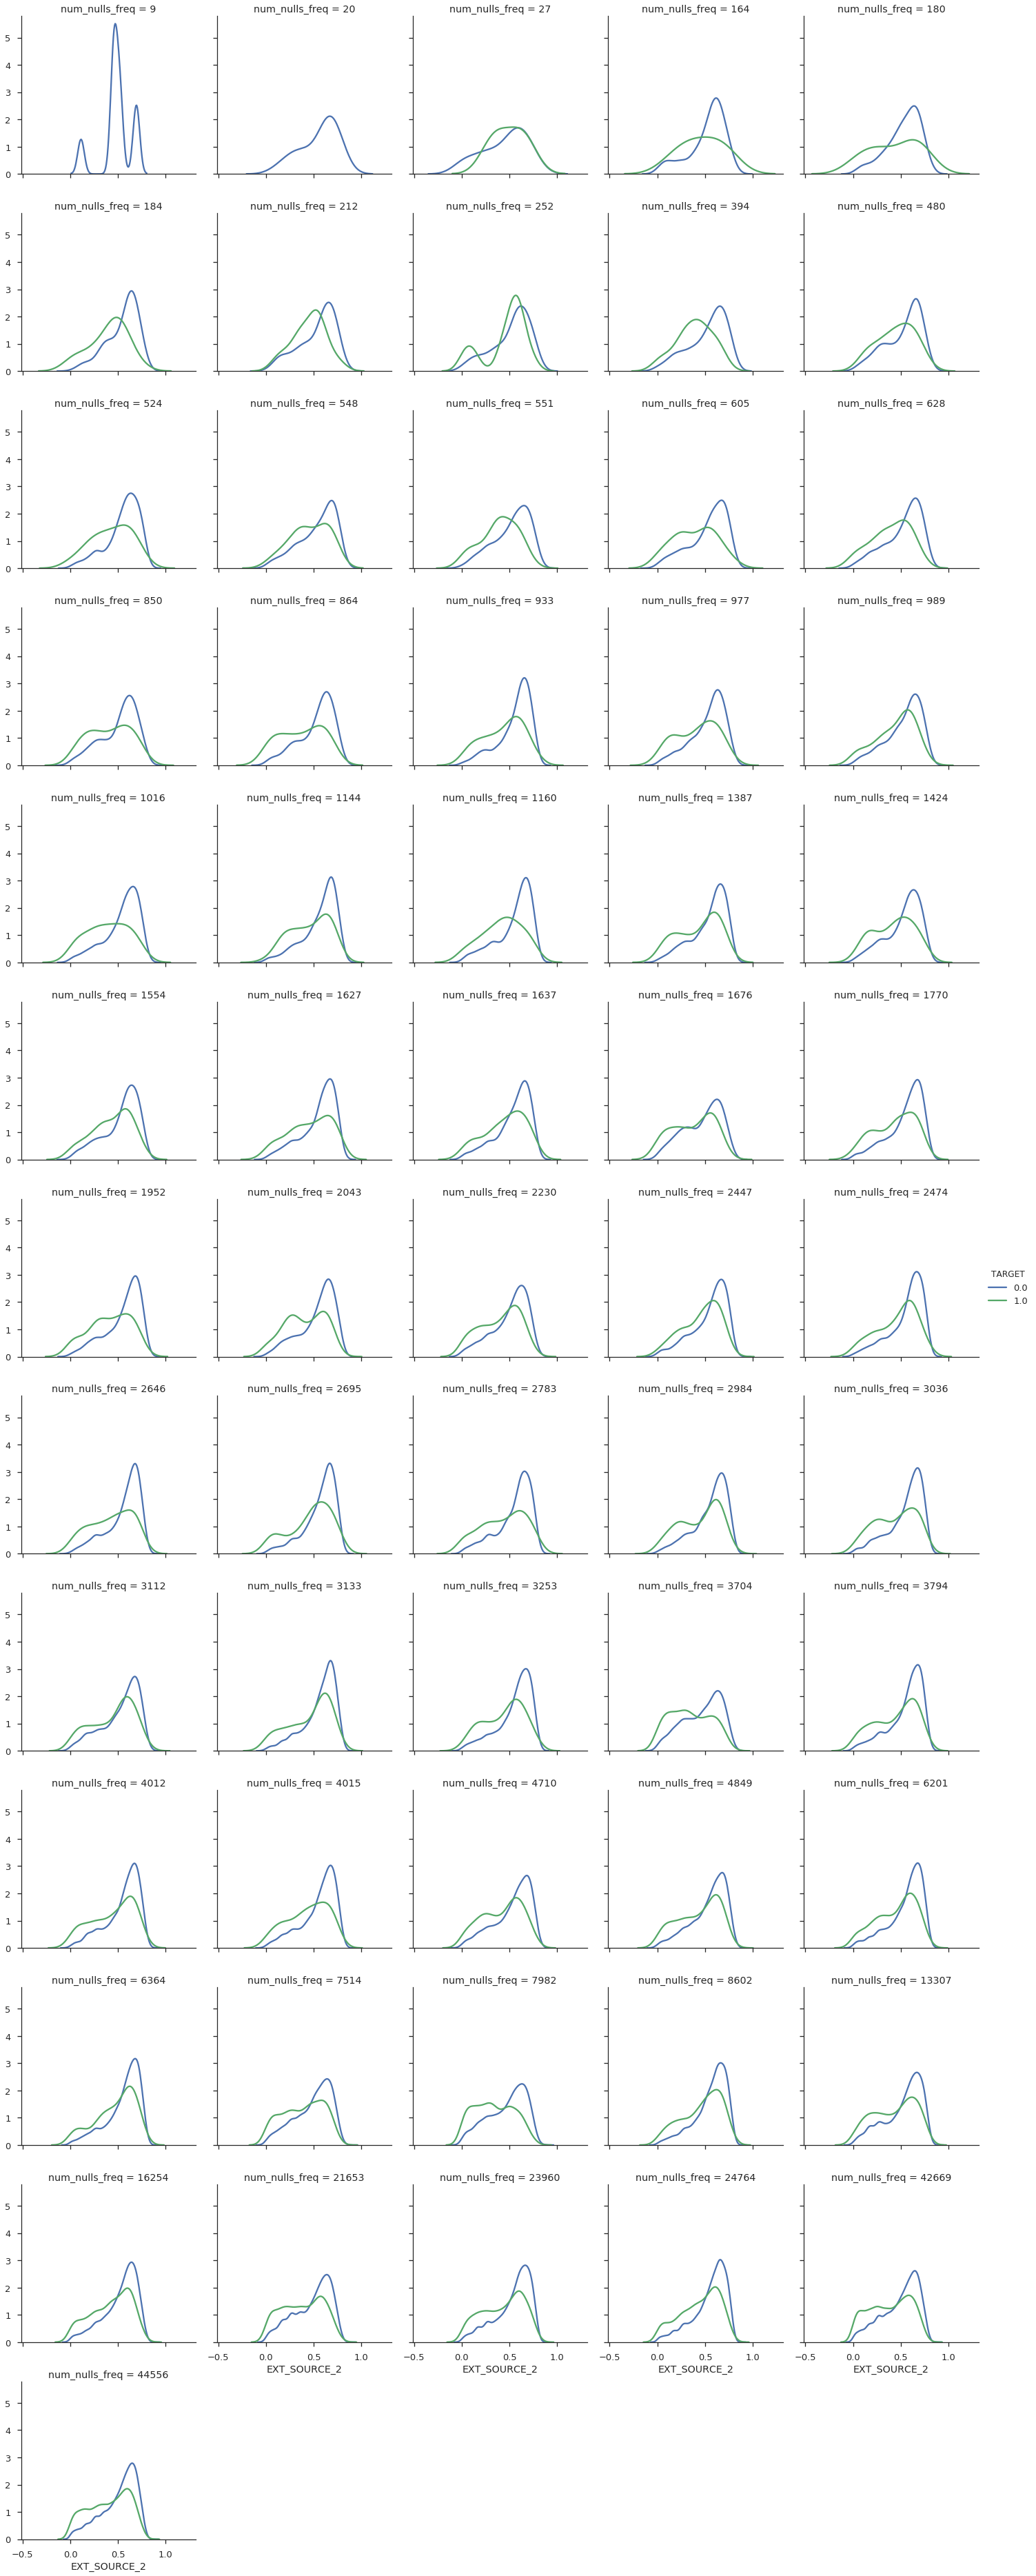

In [27]:
x                          = app_train.loc[:, ['EXT_SOURCE_2', 'TARGET']]
x.loc[:, 'num_nulls']      = num_nulls
x.loc[:, 'num_nulls_freq'] = x.groupby('num_nulls')['num_nulls'].transform(lambda x: len(x))

g = sns.FacetGrid(data=x,
                  col='num_nulls_freq',
                  hue='TARGET',
                  col_wrap=5,
                  size=4
                 )
g = g.map(sns.kdeplot, 'EXT_SOURCE_2').add_legend();

## Loan Stacking

- Multiple active loans.
- Soft credit inquiries.
- Patchy reporting of resulting loans to credit bureau.

### Patchy reporting to Bureau

In [5]:
bureau.head().T

,0,1,2,3,4
SK_ID_CURR,215354,215354,215354,215354,215354
SK_ID_BUREAU,5714462,5714463,5714464,5714465,5714466
CREDIT_ACTIVE,Closed,Active,Active,Active,Active
CREDIT_CURRENCY,currency 1,currency 1,currency 1,currency 1,currency 1
DAYS_CREDIT,-497,-208,-203,-203,-629
CREDIT_DAY_OVERDUE,0,0,0,0,0
DAYS_CREDIT_ENDDATE,-153,1075,528,NaN,1197
DAYS_ENDDATE_FACT,-153,NaN,NaN,NaN,NaN
AMT_CREDIT_MAX_OVERDUE,NaN,NaN,NaN,NaN,77674.5
CNT_CREDIT_PROLONG,0,0,0,0,0


My idea of patchy reporting would be that DAYS_CREDIT_UPDATE which is how many days befoe current application did last information about the Credit Bureau credit come. We should ideally only look at active credit.

In [55]:
x                              = bureau.loc[bureau.CREDIT_ACTIVE == 'Active', ['SK_ID_CURR', 'DAYS_CREDIT_UPDATE']]
x.loc[:, 'DAYS_CREDIT_UPDATE'] = -x.DAYS_CREDIT_UPDATE

tmp = x.groupby('SK_ID_CURR')['DAYS_CREDIT_UPDATE'].var(); tmp.head()

SK_ID_CURR
100001     25.333333
100002    144.500000
100003           NaN
100005    200.000000
100008           NaN
Name: DAYS_CREDIT_UPDATE, dtype: float64

In [57]:
res = app_train.SK_ID_CURR.map(tmp)
print(res[res.isnull()].shape[0] / len(res))

0.534823144537919


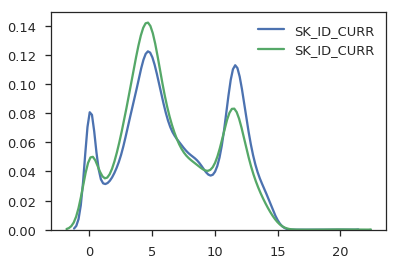

In [58]:
sns.kdeplot(res[(app_train.TARGET == 0)].map(np.log1p))
sns.kdeplot(res[(app_train.TARGET == 1)].map(np.log1p));

### Multiple Active Loans

Number of active loans reported by Credit Bureau and number of current active previous loans with Home Credit

In [61]:
bureau_loans = bureau.loc[bureau.CREDIT_ACTIVE == 'Active'].groupby('SK_ID_CURR').size()

In [66]:
home_credit_loans = prev_app.loc[(prev_app.DAYS_TERMINATION.isnull()) |\
                                 (prev_app.DAYS_TERMINATION == 365243.0), :].groupby('SK_ID_CURR').size()

In [67]:
len(bureau_loans), len(home_credit_loans)

(251815, 255285)

In [69]:
res = home_credit_loans.add(bureau_loans, fill_value=0)
res = app_train.SK_ID_CURR.map(res)

print(res[res.isnull()].shape[0] / len(res))

0.09201296864177216


In [72]:
bureau.CREDIT_ACTIVE.value_counts()

Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64

In [73]:
bureau.CREDIT_ACTIVE.cat.codes.value_counts()

2    1079273
0     630607
3       6527
1         21
dtype: int64

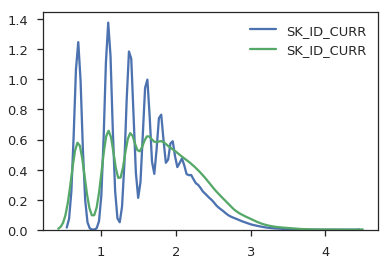

In [71]:
sns.kdeplot(res[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(res[app_train.TARGET == 1].map(np.log1p));

### Soft Credit Inquiries

If Home Credit Bureau are performing hard checks as in

1. Checking documents submitted by applicant.
1. Updates coming in from various bureaus.

In [5]:
bureau.head().T

,0,1,2,3,4
SK_ID_CURR,215354,215354,215354,215354,215354
SK_ID_BUREAU,5714462,5714463,5714464,5714465,5714466
CREDIT_ACTIVE,Closed,Active,Active,Active,Active
CREDIT_CURRENCY,currency 1,currency 1,currency 1,currency 1,currency 1
DAYS_CREDIT,-497,-208,-203,-203,-629
CREDIT_DAY_OVERDUE,0,0,0,0,0
DAYS_CREDIT_ENDDATE,-153,1075,528,NaN,1197
DAYS_ENDDATE_FACT,-153,NaN,NaN,NaN,NaN
AMT_CREDIT_MAX_OVERDUE,NaN,NaN,NaN,NaN,77674.5
CNT_CREDIT_PROLONG,0,0,0,0,0


In [43]:
tmp = bureau[(bureau.CREDIT_ACTIVE == 'Closed')].copy()

tmp.loc[:, 'duration']      = tmp.DAYS_ENDDATE_FACT - tmp.DAYS_CREDIT
tmp.loc[:, 'latest_update'] = tmp.DAYS_CREDIT - tmp.DAYS_CREDIT_UPDATE

tmp.loc[:, 'div'] = tmp.duration / tmp.latest_update
tmp = tmp.groupby('SK_ID_CURR')['div'].median()
tmp = app_train.SK_ID_CURR.map(tmp)

print(tmp[tmp.isnull()].shape[0] / len(tmp))

0.2516853055663049


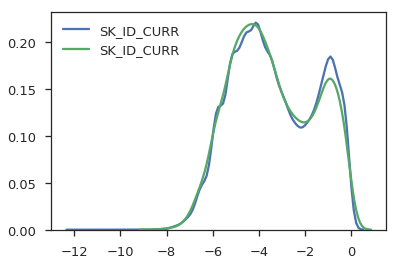

In [44]:
sns.kdeplot(tmp[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(tmp[app_train.TARGET == 1].map(np.log1p));

In [47]:
tmp = bureau[(bureau.CREDIT_ACTIVE == 'Active')].copy()

tmp.loc[:, 'duration']      = tmp.DAYS_CREDIT_ENDDATE - tmp.DAYS_CREDIT
tmp.loc[:, 'latest_update'] = tmp.DAYS_CREDIT - tmp.DAYS_CREDIT_UPDATE

tmp.loc[:, 'div'] = tmp.duration / tmp.latest_update
tmp = tmp.groupby('SK_ID_CURR')['div'].mean()
tmp = app_train.SK_ID_CURR.map(tmp)

print(tmp[tmp.isnull()].shape[0] / len(tmp))

0.3229965757322502


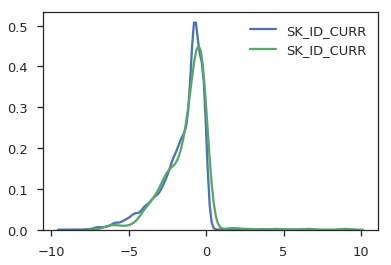

In [48]:
sns.kdeplot(tmp[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot(tmp[app_train.TARGET == 1].map(np.log1p));

In [72]:
tmp = bureau_bal.groupby('SK_ID_BUREAU').size().reset_index().rename(columns={0: 'size'})
tmp = bureau.loc[:, ['SK_ID_CURR', 'SK_ID_BUREAU']].merge(tmp, how='left')

tmp = tmp.groupby('SK_ID_CURR')['size'].std()
tmp = app_train.SK_ID_CURR.map(tmp)

print(tmp[tmp.notnull()].shape[0] / len(tmp))

0.2602996315578955


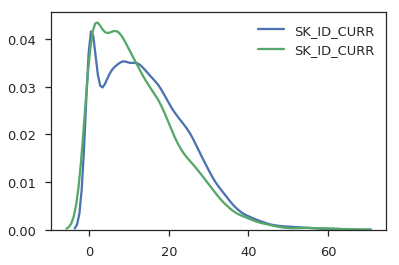

In [73]:
sns.kdeplot(tmp[app_train.TARGET == 0])
sns.kdeplot(tmp[app_train.TARGET == 1]);